In [2]:
%%capture
!pip install -r ../requirements.txt 

In [3]:
# Step 0. Import libraries and custom modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
# Preprocessing --------------------------------------------------------
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Metrics --------------------------------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Exporting ------------------------------------------------------------
import pickle

In [4]:
# Step 1. Read the dataset
# The data this week comes from Coffee Quality Database courtesy of Buzzfeed Data Scientist 
# James LeDoux. The original data can be found on James' github. The data was re-posted to Kaggle.
# These data were collected from the Coffee Quality Institute's review pages in January 2018.
# There is data for both Arabica and Robusta beans, across many countries and professionally 
# rated on a 0-100 scale. All sorts of scoring/ratings for things like acidity, sweetness, fragrance, 
# balance, etc - may be useful for either separating into visualizations/categories or for 
# modeling/recommenders.
# https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-07-07/readme.md

#url = 'https://raw.githubusercontent.com/rfordatascience/' + \
#'tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv'
url = '../data/raw/coffee.csv'
df_raw = pd.read_csv(url)
df_raw.to_csv('../data/raw/coffee.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1339 non-null   int64  
 1   total_cup_points       1339 non-null   float64
 2   species                1339 non-null   object 
 3   owner                  1332 non-null   object 
 4   country_of_origin      1338 non-null   object 
 5   farm_name              980 non-null    object 
 6   lot_number             276 non-null    object 
 7   mill                   1021 non-null   object 
 8   ico_number             1182 non-null   object 
 9   company                1130 non-null   object 
 10  altitude               1113 non-null   object 
 11  region                 1280 non-null   object 
 12  producer               1107 non-null   object 
 13  number_of_bags         1339 non-null   int64  
 14  bag_weight             1339 non-null   object 
 15  in_c

In [5]:
# Get a sample
df_raw.sample(10)

Unnamed: 0  total_cup_points  species                       owner  \
452          452             83.17  Arabica  taylor winch (coffee) ltd.   
467          467             83.17  Arabica          racafe & cia s.c.a   
1050        1050             80.67  Arabica           aulia arif syahri   
194          194             84.25  Arabica   juan luis alvarado romero   
1239        1239             78.00  Arabica            samuel eli gurel   
816          816             81.92  Arabica   juan luis alvarado romero   
937          937             81.42  Arabica                     cadexsa   
219          219             84.17  Arabica                  ceca, s.a.   
1022        1022             80.92  Arabica             ipanema coffees   
850          850             81.83  Arabica          racafe & cia s.c.a   

     country_of_origin     farm_name   lot_number  \
452              Kenya           NaN          NaN   
467           Colombia           NaN          NaN   
1050         Indonesia       darmawi          NaN   
194          Guatemala  finca medina  11/11711/59   
1239             China          hani          NaN   
816          Guatemala  las delicias   11/23/0515   
937           Honduras   cerro bueno          NaN   
219         Costa Rica        gamboa          NaN   
1022            Brazil     rio verde          NaN   
850           Colombia           NaN          NaN   

                                 mill     ico_number  \
452                               NaN   37-0843-3305   
467                               NaN      3-37-1691   
1050     surbakti / pt.olam indonesia   015/1691/006   
194   beneficio siembras vision (154)    11/11711/59   
1239                             hani             na   
816                  beneficio ixchel     11/23/0515   
937                           cadexsa      13-63-204   
219   beneficio montañas del diamante     5-025-0111   
1022                  ipanema coffees  002/1660/0065   
850                               NaN      3-37-2547   

                        company  ...         color category_two_defects  \
452   taylor winch (coffee) ltd  ...  Bluish-Green                    1   
467      c.i.racafe & cia s.c.a  ...         Green                    2   
1050         pt. olam indonesia  ...    Blue-Green                    1   
194       siembras vision, s.a.  ...         Green                    4   
1239    greenhouse coffee china  ...         Green                   28   
816        unex guatemala, s.a.  ...         Green                    0   
937                     cadexsa  ...         Green                    1   
219                   ceca,s.a.  ...    Blue-Green                    0   
1022            ipanema coffees  ...          None                    0   
850          racafe & cia s.c.a  ...  Bluish-Green                    0   

               expiration                          certification_body  \
452        July 2nd, 2016            Kenya Coffee Traders Association   
467     August 31st, 2013                                    Almacafé   
1050   November 9th, 2016                Specialty Coffee Association   
194        May 23rd, 2017                Asociacion Nacional Del Café   
1239  September 5th, 2014                Specialty Coffee Association   
816       June 22nd, 2018                Asociacion Nacional Del Café   
937        May 11th, 2016                Instituto Hondureño del Café   
219       April 9th, 2016  Specialty Coffee Association of Costa Rica   
1022   October 16th, 2015                Specialty Coffee Association   
850       July 19th, 2014                                    Almacafé   

                         certification_address  \
452   ccba45b89d859740b749878be8c6d16fbdb96c2e   
467   e493c36c2d076bf273064f7ac23ad562af257a25   
1050  36d0d00a3724338ba7937c52a378d085f2172daa   
194   b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53   
1239  36d0d00a3724338ba7937c52a378d085f2172daa   
816   b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53   

In [6]:
# Select metrics
df_interim = df_raw.copy()
df_interim = df_interim[['total_cup_points',
                            'species',
                            'country_of_origin',
                            'variety',
                            'aroma',
                            'aftertaste',
                            'acidity',
                            'body',
                            'balance',
                            'sweetness',
                            'altitude_mean_meters',
                            'moisture']] #criterio algunos datos son irrelevantes apra la predicción
df_interim = df_interim.dropna()

In [7]:
# Get a sample
df_interim.sample(10)

total_cup_points  species country_of_origin  variety  aroma  aftertaste  \
314              83.67  Arabica            Brazil  Bourbon   7.67        7.50   
914              81.50  Arabica            Taiwan   Typica   7.50        7.33   
1308             63.08  Arabica         Nicaragua  Caturra   7.25        6.33   
195              84.25  Arabica         Guatemala  Caturra   7.75        7.50   
1251             77.50  Arabica            Mexico   Typica   7.17        6.58   
1120             80.08  Arabica            Mexico   Typica   7.33        7.25   
348              83.58  Arabica            Mexico   Typica   7.83        7.58   
699              82.42  Arabica            Mexico  Bourbon   7.67        7.33   
698              82.42  Arabica            Mexico  Caturra   7.58        7.33   
941              81.42  Arabica         Guatemala  Bourbon   7.42        7.17   

      acidity  body  balance  sweetness  altitude_mean_meters  moisture  
314      7.67  7.67     7.50       10.0              890.0000      0.11  
914      7.08  7.58     7.25       10.0              180.0000      0.12  
1308     6.25  6.42     6.08        6.0             1100.0000      0.13  
195      8.08  7.58     7.67       10.0             1099.4136      0.10  
1251     6.75  6.83     6.75       10.0             1300.0000      0.13  
1120     7.08  7.08     7.08       10.0             1300.0000      0.15  
348      7.58  7.67     7.58       10.0             1000.0000      0.12  
699      7.42  7.58     7.33       10.0             1250.0000      0.13  
698      7.58  7.50     7.50       10.0             1150.0000      0.11  
941      7.42  7.42     7.42       10.0             1550.0000      0.10

In [8]:
# Transform
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 1 to 1333
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_cup_points      997 non-null    float64
 1   species               997 non-null    object 
 2   country_of_origin     997 non-null    object 
 3   variety               997 non-null    object 
 4   aroma                 997 non-null    float64
 5   aftertaste            997 non-null    float64
 6   acidity               997 non-null    float64
 7   body                  997 non-null    float64
 8   balance               997 non-null    float64
 9   sweetness             997 non-null    float64
 10  altitude_mean_meters  997 non-null    float64
 11  moisture              997 non-null    float64
dtypes: float64(9), object(3)
memory usage: 101.3+ KB


In [9]:
# Transformo las variables categoricas
df_interim['species'] = pd.Categorical(df_interim['species'])
df_interim['country_of_origin'] = pd.Categorical(df_interim['country_of_origin'])
df_interim['variety'] = pd.Categorical(df_interim['variety'])

In [10]:
# We'll divide our cup point into two classes: specialty or not
# All coffees with over 80 points are considered specialty, we'll use the median as separator
# https://nobletreecoffee.com/coffee-cupping/
df_interim['specialty'] = df_interim['total_cup_points'].apply(lambda x: 'Yes' if x>82.43 else 'No')

In [11]:
# Save to final dataset
df_interim.to_csv('../data/interim/coffee.csv')
df = df_interim.copy()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 1 to 1333
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   total_cup_points      997 non-null    float64 
 1   species               997 non-null    category
 2   country_of_origin     997 non-null    category
 3   variety               997 non-null    category
 4   aroma                 997 non-null    float64 
 5   aftertaste            997 non-null    float64 
 6   acidity               997 non-null    float64 
 7   body                  997 non-null    float64 
 8   balance               997 non-null    float64 
 9   sweetness             997 non-null    float64 
 10  altitude_mean_meters  997 non-null    float64 
 11  moisture              997 non-null    float64 
 12  specialty             997 non-null    object  
dtypes: category(3), float64(9), object(1)
memory usage: 91.3+ KB


In [13]:
# Proceed to train test split
X = df.drop(['total_cup_points','specialty'], axis=1)
y = df['specialty']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y)
df_train = pd.concat([X_train, y_train], axis=1)

In [14]:
df_train

species country_of_origin         variety  aroma  aftertaste  acidity  \
780   Arabica            Brazil  Yellow Bourbon   7.25        7.58     7.58   
1293  Arabica          Honduras           Pacas   7.00        6.83     7.17   
1223  Arabica            Mexico         Caturra   7.25        7.00     6.83   
157   Arabica            Brazil          Catuai   8.50        7.50     7.75   
520   Arabica            Mexico         Bourbon   7.50        7.50     7.50   
...       ...               ...             ...    ...         ...      ...   
428   Arabica          Colombia         Caturra   7.83        7.67     7.33   
236   Arabica         Guatemala         Bourbon   7.58        7.67     8.00   
129   Arabica         Guatemala         Bourbon   7.75        7.58     8.00   
145   Arabica          Colombia           Other   7.83        7.58     7.92   
911   Arabica         Nicaragua         Caturra   7.50        7.33     7.33   

      body  balance  sweetness  altitude_mean_meters  moisture specialty  
780   7.25     7.92       10.0                   1.0      0.00        No  
1293  7.00     7.17        8.0                1350.0      0.11        No  
1223  7.58     7.08       10.0                1200.0      0.13        No  
157   7.50     7.83       10.0                1100.0      0.11       Yes  
520   7.58     7.58       10.0                1200.0      0.11       Yes  
...    ...      ...        ...                   ...       ...       ...  
428   7.67     7.67       10.0                1750.0      0.11       Yes  
236   7.75     7.67       10.0                1550.0      0.10       Yes  
129   7.92     7.75       10.0                1600.0      0.10       Yes  
145   7.67     7.83       10.0                1500.0      0.00       Yes  
911   7.25     7.33       10.0                1100.0      0.11        No  

[747 rows x 12 columns]

In [15]:
# Sample
X.sample(10)

species country_of_origin  variety  aroma  aftertaste  acidity  body  \
1206  Arabica         Nicaragua  Caturra   7.17        6.92     7.00  7.00   
79    Arabica             Kenya     SL34   7.83        7.75     8.08  7.92   
48    Arabica             Kenya     SL28   7.92        7.83     8.50  7.50   
1182  Arabica            Taiwan   Typica   7.08        6.83     7.25  7.42   
880   Arabica            Brazil  Bourbon   7.25        7.25     7.50  7.50   
15    Arabica     United States    Other   8.00        8.58     8.17  8.17   
1064  Arabica          Honduras  Caturra   7.50        7.00     7.42  7.33   
280   Arabica            Taiwan   Typica   7.67        7.67     7.75  7.42   
663   Arabica         Guatemala  Bourbon   7.83        7.33     7.67  7.42   
310   Arabica         Guatemala  Caturra   7.67        7.58     7.67  7.75   

      balance  sweetness  altitude_mean_meters  moisture  
1206     7.00       10.0               1100.00      0.10  
79       7.75       10.0               1600.00      0.00  
48       7.92       10.0               1860.00      0.11  
1182     7.08       10.0                850.00      0.11  
880      7.42       10.0               1260.00      0.10  
15       8.00       10.0               2080.00      0.00  
1064     7.00       10.0               1400.00      0.11  
280      7.75       10.0                525.00      0.00  
663      7.50       10.0               1310.64      0.12  
310      7.75       10.0               1300.00      0.11

In [16]:
# Get basic statistics
X_train.describe().T # sweetness, altitude_mean_meters y ? no tienen poder predictivo

count         mean           std   min      25%  \
aroma                 747.0     7.565850      0.310261  5.08     7.42   
aftertaste            747.0     7.386948      0.337051  6.17     7.17   
acidity               747.0     7.525877      0.313565  5.25     7.33   
body                  747.0     7.509652      0.271466  6.42     7.33   
balance               747.0     7.497617      0.341907  6.08     7.33   
sweetness             747.0     9.913802      0.487428  1.33    10.00   
altitude_mean_meters  747.0  1995.235849  10551.255592  1.00  1100.00   
moisture              747.0     0.094177      0.044333  0.00     0.10   

                          50%      75%        max  
aroma                    7.58     7.75       8.75  
aftertaste               7.42     7.58       8.50  
acidity                  7.50     7.67       8.58  
body                     7.50     7.67       8.42  
balance                  7.50     7.67       8.58  
sweetness               10.00    10.00      10.00  
altitude_mean_meters  1317.00  1600.00  190164.00  
moisture                 0.11     0.12       0.17

In [17]:
X_train.describe(include='category') # species no tiene poder predictivo

species country_of_origin  variety
count       747               747      747
unique        2                31       26
top     Arabica            Mexico  Caturra
freq        745               173      180

In [18]:
X_train['species'].value_counts()

Arabica    745
Robusta      2
Name: species, dtype: int64

In [19]:
X_train['country_of_origin'].value_counts()

Mexico                          173
Guatemala                       101
Colombia                         99
Brazil                           77
Taiwan                           49
Honduras                         39
Costa Rica                       32
Tanzania, United Republic Of     24
Uganda                           19
Kenya                            18
China                            14
El Salvador                      14
Indonesia                        13
Nicaragua                        13
Ethiopia                         11
Malawi                            9
Myanmar                           7
Thailand                          4
Haiti                             4
United States                     4
Vietnam                           4
Laos                              3
Panama                            3
United States (Puerto Rico)       3
Peru                              2
Philippines                       2
India                             2
Burundi                     

In [20]:
X_train['country_of_origin'].value_counts(normalize=True) # Para pasar a porcentaje la producción de Café por País
# Regla de Paretto, 80/20, sumo los que tienen más % de incidencia y me quedo con esos

Mexico                          0.231593
Guatemala                       0.135207
Colombia                        0.132530
Brazil                          0.103079
Taiwan                          0.065596
Honduras                        0.052209
Costa Rica                      0.042838
Tanzania, United Republic Of    0.032129
Uganda                          0.025435
Kenya                           0.024096
China                           0.018742
El Salvador                     0.018742
Indonesia                       0.017403
Nicaragua                       0.017403
Ethiopia                        0.014726
Malawi                          0.012048
Myanmar                         0.009371
Thailand                        0.005355
Haiti                           0.005355
United States                   0.005355
Vietnam                         0.005355
Laos                            0.004016
Panama                          0.004016
United States (Puerto Rico)     0.004016
Peru            

In [21]:
X_train['variety'].value_counts()

Caturra                  180
Typica                   152
Bourbon                  149
Other                     81
Catuai                    53
Yellow Bourbon            23
Mundo Novo                20
Catimor                   17
SL14                      12
Pacas                     10
Gesha                     10
SL28                      10
SL34                       8
Pacamara                   7
Java                       2
Mandheling                 2
Sumatra                    2
Ruiru 11                   1
Sulawesi                   1
Ethiopian Heirlooms        1
Peaberry                   1
Ethiopian Yirgacheffe      1
Blue Mountain              1
Moka Peaberry              1
Marigojipe                 1
Sumatra Lintong            1
Pache Comun                0
Arusha                     0
Name: variety, dtype: int64

In [22]:
X_train['variety'].value_counts(normalize=True) 

Caturra                  0.240964
Typica                   0.203481
Bourbon                  0.199465
Other                    0.108434
Catuai                   0.070950
Yellow Bourbon           0.030790
Mundo Novo               0.026774
Catimor                  0.022758
SL14                     0.016064
Pacas                    0.013387
Gesha                    0.013387
SL28                     0.013387
SL34                     0.010710
Pacamara                 0.009371
Java                     0.002677
Mandheling               0.002677
Sumatra                  0.002677
Ruiru 11                 0.001339
Sulawesi                 0.001339
Ethiopian Heirlooms      0.001339
Peaberry                 0.001339
Ethiopian Yirgacheffe    0.001339
Blue Mountain            0.001339
Moka Peaberry            0.001339
Marigojipe               0.001339
Sumatra Lintong          0.001339
Pache Comun              0.000000
Arusha                   0.000000
Name: variety, dtype: float64

In [23]:
# Analyze
X_train.sort_values(by='altitude_mean_meters', ascending=False).head(20)

species             country_of_origin        variety  aroma  aftertaste  \
896   Arabica                     Guatemala        Bourbon   7.42        7.08   
1144  Arabica                     Guatemala        Bourbon   7.50        7.25   
1040  Arabica                     Nicaragua          Other   7.25        7.17   
543   Arabica                        Brazil  Moka Peaberry   7.08        7.50   
840   Arabica                       Myanmar         Catuai   7.33        7.50   
1123  Arabica                       Myanmar          Other   7.17        7.00   
1038  Arabica                       Myanmar         Catuai   6.92        7.00   
1073  Arabica                       Myanmar          Other   7.17        7.17   
1269  Arabica                     Indonesia          Other   7.33        6.50   
837   Arabica                     Guatemala        Bourbon   7.58        7.33   
215   Arabica                     Guatemala        Bourbon   7.58        7.58   
193   Arabica                      Colombia        Caturra   7.83        7.75   
89    Arabica                      Colombia        Caturra   8.17        7.58   
800   Arabica                        Malawi          Gesha   7.50        7.33   
682   Arabica  Tanzania, United Republic Of       Ruiru 11   7.67        7.42   
349   Arabica                      Colombia        Caturra   7.67        7.58   
92    Arabica                      Colombia        Caturra   7.83        7.75   
23    Arabica                 United States          Other   8.25        8.17   
419   Arabica                     Guatemala          Pacas   7.50        7.42   
4     Arabica                      Ethiopia          Other   8.25        8.25   

      acidity  body  balance  sweetness  altitude_mean_meters  moisture  
896      7.50  7.42     7.33      10.00              190164.0      0.12  
1144     7.58  7.33     7.42       9.33              190164.0      0.10  
1040     7.25  7.33     7.25      10.00              110000.0      0.12  
543      7.83  7.75     7.67      10.00               11000.0      0.11  
840      7.42  7.33     7.33      10.00                4001.0      0.00  
1123     7.42  7.17     7.00      10.00                3845.0      0.00  
1038     7.58  7.50     7.08      10.00                3825.0      0.00  
1073     7.42  7.25     7.08      10.00                3800.0      0.00  
1269     6.08  7.58     6.33       9.33                3500.0      0.12  
837      7.42  7.58     7.25      10.00                3280.0      0.10  
215      7.83  7.83     7.67      10.00                3280.0      0.10  
193      7.58  7.67     8.00      10.00                2560.0      0.11  
89       8.08  8.00     7.75      10.00                2560.0      0.00  
800      7.58  7.33     7.50      10.00                2500.0      0.13  
682      7.42  7.67     7.42      10.00                2285.0      0.13  
349      7.58  7.67     7.75      10.00                2136.0      0.11  
92       7.75  7.83     7.83      10.00                2136.0      0.11  
23       8.17  7.83     8.17      10.00                2112.0      0.00  
419      7.83  7.67     7.58      10.00                2100.0      0.11  
4        8.50  8.42     8.33      10.00                2075.0      0.12

In [24]:
# Given the excess of categories in country and variety, we'll aggregate 
# low values into others (using Pareto's rule or a minimum of 50 observations)
top_varieties = ['Caturra', 'Typica', 'Bourbon', 'Catuai']
df_interim['variety'] = df_interim['variety'].apply(lambda x: x if x in top_varieties else 'Other')
top_country = ['Mexico', 'Guatemala', 'Colombia', 'Brazil', 'Taiwan']
df_interim['country_of_origin'] = df_interim['country_of_origin'].apply(lambda x: x if x in top_country else 'Other')
df_interim.variety = pd.Categorical(df_interim.variety)
df_interim.country_of_origin = pd.Categorical(df_interim.country_of_origin)
df_interim['specialty'] = df_interim['total_cup_points'].apply(lambda x: 'Yes' if x>82.43 else 'No')
df_interim.specialty = pd.Categorical(df_interim.specialty)

In [25]:
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 1 to 1333
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   total_cup_points      997 non-null    float64 
 1   species               997 non-null    category
 2   country_of_origin     997 non-null    category
 3   variety               997 non-null    category
 4   aroma                 997 non-null    float64 
 5   aftertaste            997 non-null    float64 
 6   acidity               997 non-null    float64 
 7   body                  997 non-null    float64 
 8   balance               997 non-null    float64 
 9   sweetness             997 non-null    float64 
 10  altitude_mean_meters  997 non-null    float64 
 11  moisture              997 non-null    float64 
 12  specialty             997 non-null    category
dtypes: category(4), float64(9)
memory usage: 82.4 KB


In [26]:
df = df_interim.copy()
df_interim.to_csv('../data/interim/coffee_interim.csv')

In [27]:
# Again, train and test
X = df.drop(["total_cup_points", "specialty", "altitude_mean_meters", "sweetness", "species"], axis=1)
y = df["specialty"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y)
df_train = pd.concat([X_train, y_train], axis=1)

In [28]:
# Get info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 780 to 911
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country_of_origin  747 non-null    category
 1   variety            747 non-null    category
 2   aroma              747 non-null    float64 
 3   aftertaste         747 non-null    float64 
 4   acidity            747 non-null    float64 
 5   body               747 non-null    float64 
 6   balance            747 non-null    float64 
 7   moisture           747 non-null    float64 
 8   specialty          747 non-null    category
dtypes: category(3), float64(6)
memory usage: 43.6 KB


In [29]:
# Get stats
X_train.describe().T

count      mean       std   min   25%   50%   75%   max
aroma       747.0  7.565850  0.310261  5.08  7.42  7.58  7.75  8.75
aftertaste  747.0  7.386948  0.337051  6.17  7.17  7.42  7.58  8.50
acidity     747.0  7.525877  0.313565  5.25  7.33  7.50  7.67  8.58
body        747.0  7.509652  0.271466  6.42  7.33  7.50  7.67  8.42
balance     747.0  7.497617  0.341907  6.08  7.33  7.50  7.67  8.58
moisture    747.0  0.094177  0.044333  0.00  0.10  0.11  0.12  0.17

In [30]:
# Describe categories
X_train.describe(include='category')

country_of_origin variety
count                747     747
unique                 6       5
top                Other   Other
freq                 248     213

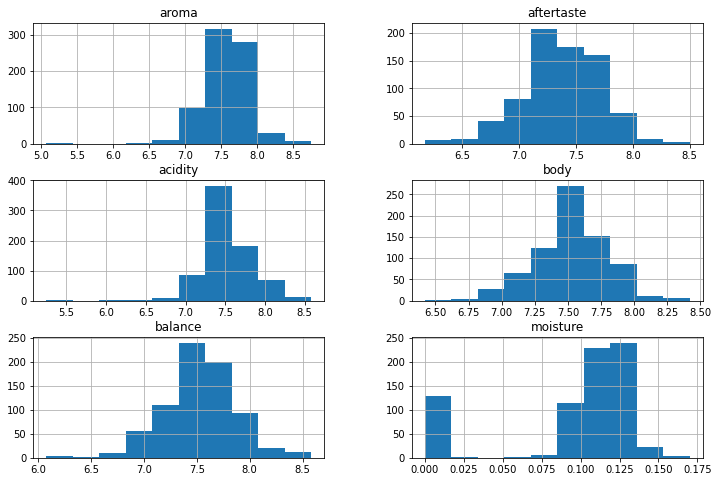

In [31]:
# Plot histograms
X_train.hist(figsize=(12,8))
plt.show()

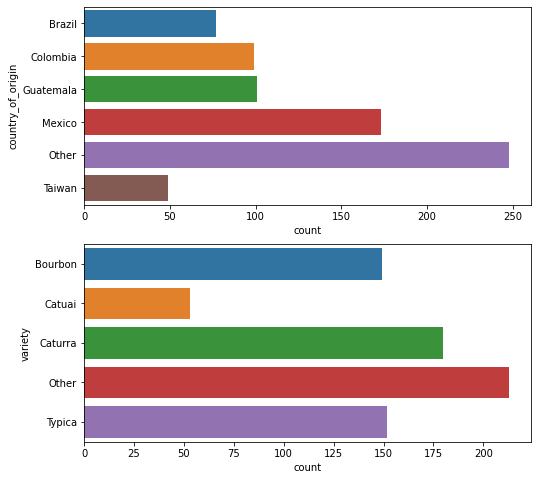

In [32]:
# Plot categories countplot
cats = X_train.select_dtypes('category')
fig, ax = plt.subplots(2,1, figsize=(8,8))
axs = ax.flatten()
for i in range(len(axs)):
    sns.countplot(data=cats, y=cats.columns.to_list()[i],ax=axs[i])

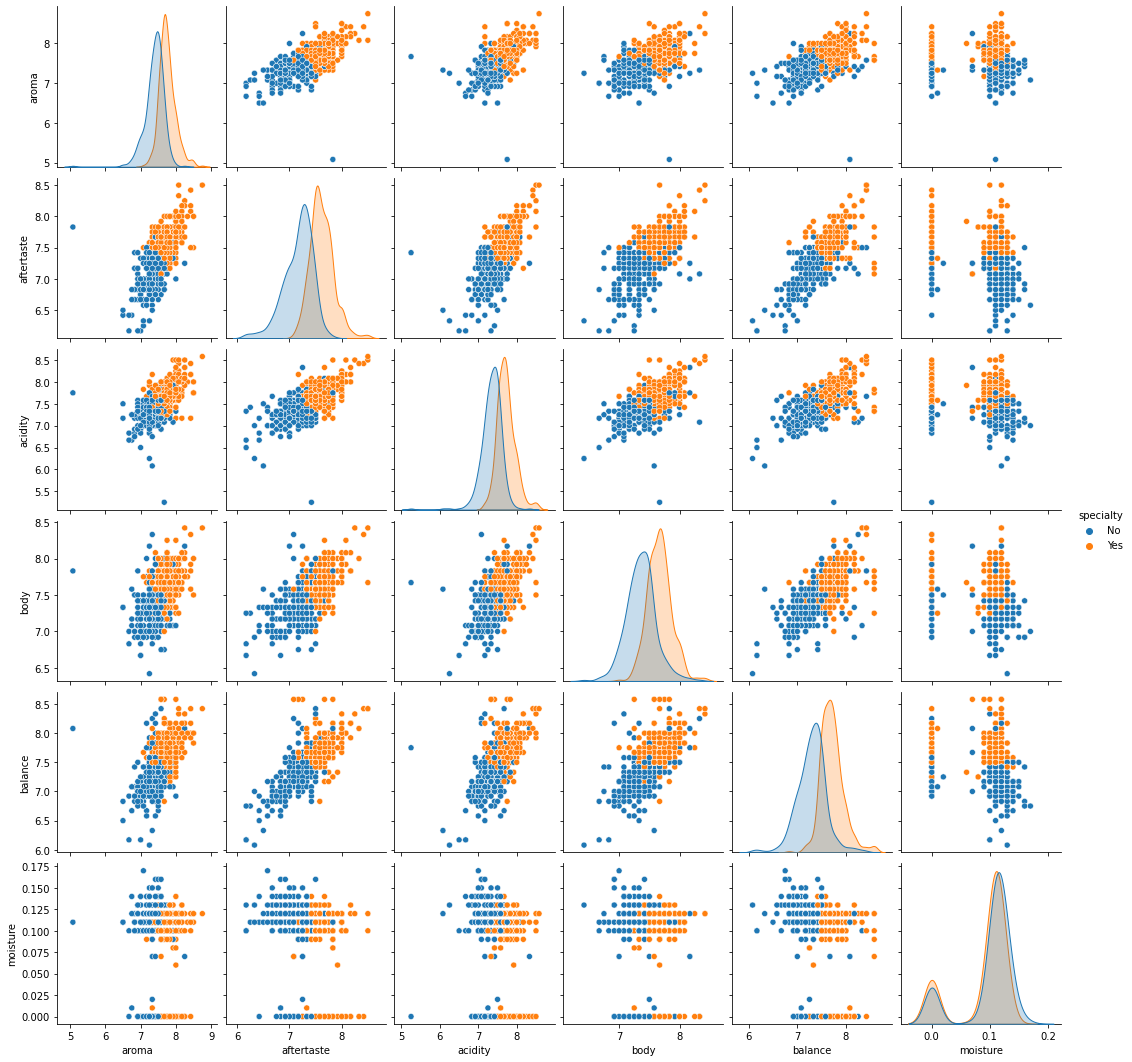

In [33]:
# Plot pairplot
sns.pairplot(data=df_train, hue='specialty')
plt.show()

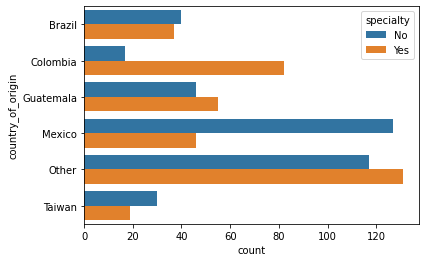

In [34]:
# Plot category effect
sns.countplot(data=df_train, y='country_of_origin', hue='specialty')
plt.show()

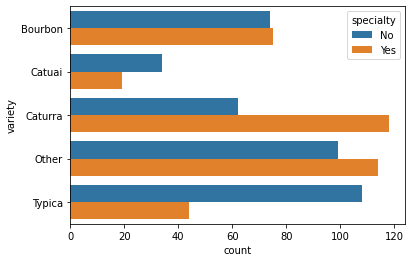

In [35]:
# Plot category effect
sns.countplot(data=df_train, y='variety', hue='specialty')
plt.show()

In [36]:
# Calculate correlation
X_train.corr().style.background_gradient(cmap='Blues')

In [37]:
# 3.1 Create your pipeline processing
# https://stackoverflow.com/questions/61641852/
# https://jaketae.github.io/study/sklearn-pipeline/
cat_cols = X_train.select_dtypes(include='category').columns
num_cols = X_train.select_dtypes(include='number').columns

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))
])

num_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

encode_data = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [38]:
# 3.2 Perform model fit
rforest = Pipeline(steps=[('preprocessor',preprocessor),('classifier',RandomForestClassifier())])
rforest.fit(X_train, y_train)
print(f'Accuracy: {rforest.score(X_train, y_train):.3f}')

Accuracy: 1.000


              precision    recall  f1-score   support

          No       0.95      0.91      0.93       126
         Yes       0.91      0.95      0.93       124

    accuracy                           0.93       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.93      0.93      0.93       250



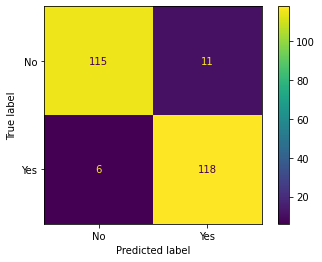

In [39]:
# 3.4 Calculate metrics on model
y_pred = rforest.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rforest.classes_).plot()
plt.show()

In [40]:
# Get variable importance
names = []
names.extend(num_cols)
cats_names = rforest.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names().tolist()
names.extend(cats_names)
imp = rforest.named_steps['classifier'].feature_importances_

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


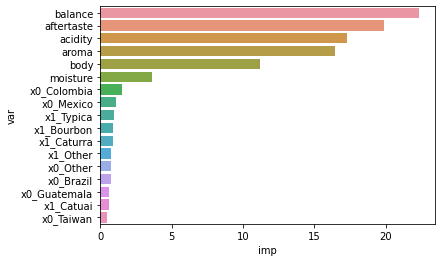

In [41]:
# Plot variable importance
bar_imp = pd.DataFrame({'var':names,'imp':imp * 100}).sort_values(by='imp', ascending=False)
sns.barplot(data=bar_imp, x='imp', y='var')
plt.show()

In [42]:
# Save the model as a pickle
filename = '../models/coffee_model.pkl'
pickle.dump(rforest, open(filename,'wb'))

In [43]:
# Create a set for testing
example = ['Other', 'Other', 7.42, 7.33, 7.42, 7.25, 7.33, 0]
example_df = pd.DataFrame(np.array(example).reshape(1,8), columns=X_train.columns)

In [44]:
# Predcit based on the set
rforest.predict(example_df)

array(['No'], dtype=object)

In [2]:
!pip freeze > ../requirementsV2.txt